# Permeation method for hydrogen transport properties in molten salt

In this notebook we'll describe the method employed to estimate the diffusivity and solubility of hydrogen in molten salt using a permeation rig.

The principle of the measurement is to have hydrogen diffusing through a membrane (here a salt, with a negligible metal membrane). The upstream pressure is kept constant and the downstream volume will experience a pressure rise. The steady state pressure rise then gives information on the salt permeability and the time-lag (detailed below) gives an insight on the diffusivity. The ratio of the permeability and diffusivity yields the solubility.

Note: having a closed downstream volume slightly differs from Fukada's experiment on FLiNaK (2006) where the authors swept the downstream gas at a constant rate.

The experimental pressure rise will be mimicked by an analytical solution and we will then quantify the error propagation.

## Generating the data
Let us first find the salt properties in the literature using HTM. We will use the Fukada 2006 paper.

In [10]:
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()

D_flinak = htm.diffusivities.filter(author="fukada", year=2006, material="flinak")[0]
K_flinak = htm.solubilities.filter(author="fukada", year=2006, material="flinak")[0]

print("Diffusivity:")
print(D_flinak)
print("Solubility:")
print(K_flinak)

Diffusivity:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 3.70182971256802e-06 m ** 2 / s
        Activation energy: 0.4504583882835244 eV
        
Solubility:

        Author: Fukada
        Material: flinak
        Year: 2006
        Isotope: H
        Pre-exponential factor: 2.030613452666854e+17 particle / Pa / m ** 3
        Activation energy: -0.3717113981444368 eV
        


The experimental parameters:

In [11]:
import numpy as np

T = ureg.Quantity(900, ureg.K)  # temperature
V_down = 1000 * ureg.cm**3  # downstream volume
A = 2 * ureg.cm**2  # gas/salt interface surface area 
P_up = 1 * ureg.atm  # upstream pressure
L = 40 * ureg.mm  # salt thickness

# estimate properties at operating temperature
D_flinak = D_flinak.value(T.to(ureg.K).magnitude) * D_flinak.units
K_flinak = K_flinak.value(T.to(ureg.K).magnitude) * K_flinak.units
permeability = D_flinak * K_flinak
print(f"{D_flinak=:~}")
print(f"{K_flinak=:~}")

D_flinak=1.1113808953304486e-08 m ** 2 / s
K_flinak=2.4501912127738196e+19 particle / Pa / m ** 3


We can now compute the transient analytical solution describing the downstream pressure rise.

$$P_\mathrm{down}(t) = R_g \ T \frac{A}{L \ V_\mathrm{down}} \ \Phi \ P_\mathrm{up} \left[t - \frac{L^2}{6 \ D} - \frac{2 \ L^2}{\pi^2 D} \sum_{n=1}^\infty \frac{(-1)^{n+1}}{n^2} \exp{\left( -\frac{D \ n^2 \pi^2}{L^2} t \right)}\right] $$

where $P_\mathrm{up}$ is the upstream pressure, $T$ is the temperature, $V$ is the downstream volume, $L$ is the thickness of salt, $R_g$ is the gas constant, and $A$ is the surface area of the gas/salt interface in the downstream chamber.

For more details, see:
- [Review of time lag permeation technique as a method for characterisation of porous media and membranes](https://link.springer.com/article/10.1007/BF01653631)
- [Hydrogen transport and trapping in ODS-EUROFER](https://doi.org/10.1016/j.fusengdes.2007.02.002)

In [4]:
timelag = L**2 / (6 * D_flinak)
Rg = htm.Rg * ureg.Pa * ureg.m**3 * ureg.mol**-1 * ureg.K**-1  # gas constant

# Analytical solution for transient downstream pressure rise
def downstream_pressure(t):


    sum_term = 0
    for n in np.arange(1, 1000):
        sum_term += (
            (-1) ** (n+1) / n**2 * np.exp(-D_flinak * n**2 * np.pi**2 * t / L**2)
        )

    transient_term = 2 * L**2 / (np.pi**2 * D_flinak) * sum_term
    return Rg * T / V_down * A / L * permeability * P_up * (t - timelag + transient_term)

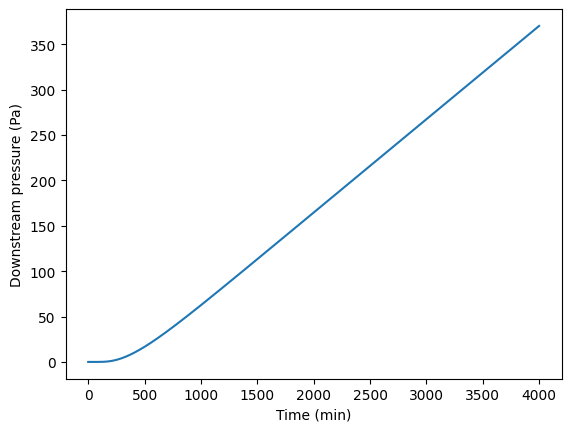

In [5]:
import matplotlib.pyplot as plt

t = (np.arange(0, 10 * timelag.to(ureg.second).magnitude, 1.0) * ureg.s).to(ureg.min)
p_down = downstream_pressure(t).to(ureg.Pa)

plt.plot(t, p_down)
plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure ({p_down.units:~})")
plt.show()


We add a noise model for the downstream pressure sensor, based on the Edwards APG200 Pirani Gauge.

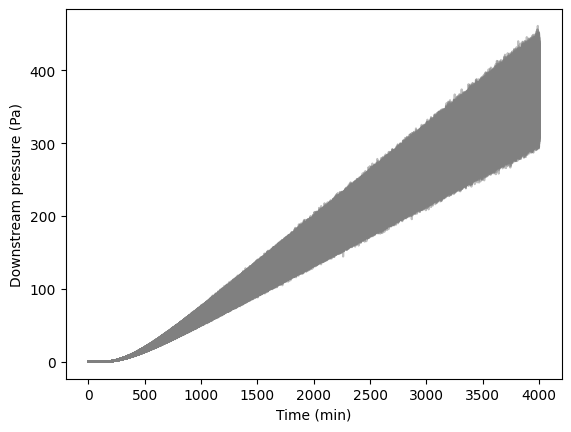

In [6]:
N_TRIALS = 400
rel_accuracy_p_down = 15 / 100
rel_repeatability_p_down = 2 / 100

noisy_p_down = np.zeros((N_TRIALS, len(t)))  # [Pa]
plt.figure()
for i in range(N_TRIALS):
    # Relative calibration/accuracy error of downstream pressure sensor for this trial.
    rel_accuracy_error = np.random.uniform(-rel_accuracy_p_down, rel_accuracy_p_down)
    # Noise on measurements of downstream pressure for this trial.
    relative_noise = np.random.normal(0, rel_repeatability_p_down, t.shape)

    noisy_p_down_this_trial = p_down.magnitude * (1 + rel_accuracy_error) * (1 + relative_noise)
    noisy_p_down_this_trial = np.clip(noisy_p_down_this_trial, 0.0, np.inf)
    noisy_p_down[i, :] = noisy_p_down_this_trial

    plt.plot(t.magnitude, noisy_p_down[i, :], color="gray", alpha=0.5)

plt.xlabel(f"Time ({t.units:~})")
plt.ylabel(f"Downstream pressure ({p_down.units:~})")
plt.show()

For each trial, we fit the steady state pressure rise for $ t > 1200 \ \mathrm{min} $ with a linear function.


In [12]:
from scipy.optimize import curve_fit


def linearFunc(x, intercept, slope):
    y = intercept + slope * x
    return y


slope_per_trial = np.zeros(N_TRIALS) # [Pa/s]
intercept_per_trial = np.zeros(N_TRIALS)  # [Pa]
# select only t > 1200 min
t_min_fit = 1200 * ureg.min
indices_fit = np.where(t > t_min_fit)
for i in range(N_TRIALS):

    t_data_fit = t[indices_fit].to(ureg.s).magnitude
    p_down_data_fit = noisy_p_down[i, indices_fit].flatten()
    data_sigma_fit = (rel_repeatability_p_down + rel_accuracy_p_down) * p_down_data_fit

    res, cov = curve_fit(
        linearFunc,
        t_data_fit,
        p_down_data_fit,
        sigma=data_sigma_fit,
        absolute_sigma=True,
    )
    intercept_per_trial[i] = res[0]
    slope_per_trial[i] = res[1]
intercept_per_trial *= ureg.Pa
slope_per_trial *= ureg.Pa / ureg.s



## Determination of H properties and uncertainty quantification

Compute solubility and diffusivity for each trial

RMS of diffusivity error = 0.6465028279372764 %
RMS of solubility error = 8.227104405398126 %


/home/mvernacc/repos/permeation_rig/.venv/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1433: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xi = np.asanyarray(xi)


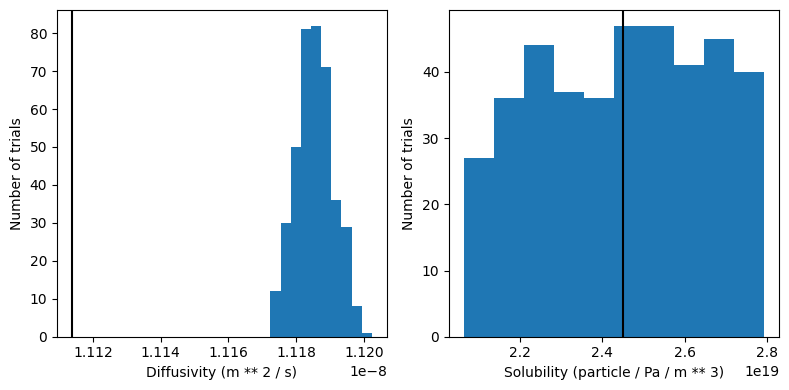

In [14]:
diffusivity_estimates = (-slope_per_trial / (6 * intercept_per_trial) * L**2).to(ureg.m**2 * ureg.s**-1)
solubility_estimates = (-6 * intercept_per_trial * V_down / (P_up * T * Rg * A * L)).to(ureg.particle * ureg.m**-3 * ureg.Pa**-1)

diffusivity_errors = ((diffusivity_estimates - D_flinak) / D_flinak).to(ureg.dimensionless).magnitude
print(f"RMS of diffusivity error = {100 * np.sqrt(np.mean(diffusivity_errors**2))} %")

solubility_errors = ((solubility_estimates - K_flinak) / K_flinak).to(ureg.dimensionless).magnitude
print(f"RMS of solubility error = {100 * np.sqrt(np.mean(solubility_errors**2))} %")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
ax_d, ax_s = axes

ax_d.hist(diffusivity_estimates)
ax_d.axvline(D_flinak, color="black")
ax_d.set_xlabel(f"Diffusivity ({D_flinak.units:~})")
ax_d.set_ylabel("Number of trials")

ax_s.hist(solubility_estimates)
ax_s.axvline(K_flinak, color="black")
ax_s.set_xlabel(f"Solubility ({K_flinak.units:~})")
ax_s.set_ylabel("Number of trials")

fig.tight_layout()